# Adding more pickup locations, Use geodesic distances and zip code and population data to enhance our BART model

University of California, Berkeley

Master of Information and Data Science (MIDS) program

w205 - Fundamentals of Data Engineering


# Included Modules and Packages

Code cell containing your includes for modules and packages

Some starter code is provided

You may change the starter code as needed

You may add as much code and/or as many code cells as you need

In [1]:
import math
import numpy as np
import pandas as pd
import neo4j

import psycopg2
import json

import gmaps
import gmaps.geojson_geometries
import matplotlib.pyplot as plt

from geographiclib.geodesic import Geodesic
from IPython.display import display

In [2]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","w205"))

In [3]:
session = driver.session(database="neo4j")

# Supporting code


In [4]:
def my_calculate_box(point, miles):
    "Given a point and miles, calculate the box in form left, right, top, bottom"
    
    geod = Geodesic.WGS84

    kilometers = miles * 1.60934
    meters = kilometers * 1000

    g = geod.Direct(point[0], point[1], 270, meters)
    left = (g['lat2'], g['lon2'])

    g = geod.Direct(point[0], point[1], 90, meters)
    right = (g['lat2'], g['lon2'])

    g = geod.Direct(point[0], point[1], 0, meters)
    top = (g['lat2'], g['lon2'])

    g = geod.Direct(point[0], point[1], 180, meters)
    bottom = (g['lat2'], g['lon2'])
    
    return(left, right, top, bottom)

In [5]:
def my_station_get_zips(station, miles):
    "given a station, pull all zip codes with miles distance, print them, sum the population"
    
    connection.rollback()
    
    query = "select latitude, longitude from stations "
    query += "where station = '" + station + "'"
    
    cursor.execute(query)
    
    connection.rollback()
    
    rows = cursor.fetchall()
    
    for row in rows:
        latitude = row[0]
        longitude = row[1]
        
    point = (latitude, longitude)
        
    (left, right, top, bottom) = my_calculate_box(point, miles)
    
    query = "select zip, population from zip_codes "
    query += " where latitude >= " + str(bottom[0])
    query += " and latitude <= " + str(top [0])
    query += " and longitude >= " + str(left[1])
    query += " and longitude <= " + str(right[1])
    query += " order by 1 "

    cursor.execute(query)
    
    connection.rollback()
    
    rows = cursor.fetchall()
    
    total_population = 0
    
    for row in rows:
        zip = row[0]
        population = row[1]
        total_population += population
    return int(total_population)

In [26]:
def my_station_get_zips_details(station, miles):
    "given a station, pull all zip codes with miles distance, print them, sum the population"
    
    connection.rollback()
    
    query = "select latitude, longitude from stations "
    query += "where station = '" + station + "'"
    
    cursor.execute(query)
    
    connection.rollback()
    
    rows = cursor.fetchall()
    
    for row in rows:
        latitude = row[0]
        longitude = row[1]
        
    point = (latitude, longitude)
        
    (left, right, top, bottom) = my_calculate_box(point, miles)
    
    query = "select zip, population from zip_codes "
    query += " where latitude >= " + str(bottom[0])
    query += " and latitude <= " + str(top [0])
    query += " and longitude >= " + str(left[1])
    query += " and longitude <= " + str(right[1])
    query += " order by 1 "

    cursor.execute(query)
    
    connection.rollback()
    
    rows = cursor.fetchall()
    
    print("\n-------------------------------------------------------------------------------")
    print("  Zip Codes within " + str(miles) + " mile(s) of " + station + " BART Station")
    print("-------------------------------------------------------------------------------\n")
    
    total_population = 0
    
    for row in rows:
        zip = row[0]
        population = row[1]
        print("     zip:", zip, "  population: ", f'{population:10,}')
        total_population += population
        
    
    print("\n-------------------------------------------------------------------------------")
    print("  Total Population: ", f'{total_population:10,}')
    print("-------------------------------------------------------------------------------")
    return total_population

In [7]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

In [8]:
#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)
    

In [9]:
def my_neo4j_shortest_path(from_station, to_station):
    "given a from station and to station, run and print the shortest path"
    
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    query = "CALL gds.graph.create('ds_graph', 'Station', 'LINK', {relationshipProperties: 'weight'})"
    session.run(query)

    query = """

    MATCH (source:Station {name: $source}), (target:Station {name: $target})
    CALL gds.shortestPath.dijkstra.stream(
        'ds_graph', 
        { sourceNode: source, 
          targetNode: target, 
          relationshipWeightProperty: 'weight'
        }
    )
    YIELD index, sourceNode, targetNode, totalCost, nodeIds, costs, path
    RETURN
        gds.util.asNode(sourceNode).name AS from,
        gds.util.asNode(targetNode).name AS to,
        totalCost,
        [nodeId IN nodeIds | gds.util.asNode(nodeId).name] AS nodes,
        costs
    ORDER BY index

    """

    result = session.run(query, source=from_station, target=to_station)
    
    for r in result:
        
        total_cost = int(r['totalCost'])
    return total_cost
    

# Connection

In [10]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

In [11]:
cursor = connection.cursor()

# Station pick (shortest path from station)

In [12]:
rollback_before_flag = True
rollback_after_flag = True

query = """

SELECT
station
FROM stations
ORDER BY 1

"""


In [13]:
all_station = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

In [14]:
all_station[:2]

,station
0,12th Street
1,16th Street Mission


In [15]:
all_station_list = all_station['station'].apply(lambda x: "{}{}".format('arrive ', x)).tolist()

In [16]:
shortest_path = []
for i in all_station_list:
    shortest_path.append(my_neo4j_shortest_path('depart Downtown Berkeley', i))

In [17]:
station_cost = all_station[['station']].copy()
station_cost["Shortest path in seconds"] = shortest_path
station_cost["Shortest path in mins"] = station_cost["Shortest path in seconds"]/60
station_cost.sort_values(by= "Shortest path in seconds", ascending= True)

,station,Shortest path in seconds,Shortest path in mins
15,Downtown Berkeley,0,0.000000
30,North Berkeley,120,2.000000
5,Ashby,180,3.000000
18,El Cerrito Plaza,300,5.000000
26,MacArthur,420,7.000000
17,El Cerrito del Norte,480,8.000000
2,19th Street,600,10.000000
39,Rockridge,719,11.983333
0,12th Street,720,12.000000
38,Richmond,780,13.000000


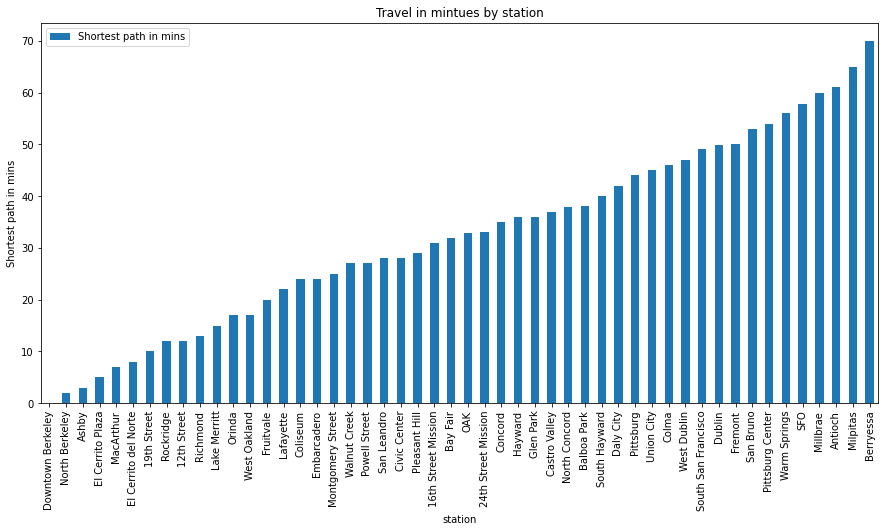

In [18]:
station_cost.sort_values(by= "Shortest path in seconds", ascending= True).plot(figsize=(15,7), x='station', y='Shortest path in mins', kind='bar')

plt.title('Travel in mintues by station')
plt.xlabel('station')
plt.ylabel('Shortest path in mins')



plt.show()



# Google Map Heat Maps

In [19]:
f = open('gmap_api_key.txt', 'r')
my_api_key = f.read()
f.close()

gmaps.configure(api_key=my_api_key)

In [122]:
# Map1 : Customers of Berkeley store

rollback_before_flag = True
rollback_after_flag = True

query = """

select z.latitude, z.longitude
from customers as cu
     join zip_codes as z
         on cu.zip = z.zip
where cu.closest_store_id = 1
order by 1,2

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,latitude,longitude
0,37.4949,-122.2080
1,37.4949,-122.2080
2,37.4949,-122.2080
3,37.4949,-122.2080
4,37.4949,-122.2080
...,...,...
8133,38.1842,-122.2629
8134,38.1842,-122.2629
8135,38.1842,-122.2629
8136,38.1842,-122.2629


In [123]:
fig = gmaps.figure(center=berkeley, map_type = 'HYBRID', zoom_level=8)

heatmap_layer = gmaps.heatmap_layer(df)

fig.add_layer(heatmap_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [20]:
# Google Map Heatmap of populations served by each BART station

In [41]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select station, latitude, longitude from stations

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,station,latitude,longitude
0,12th Street,37.803608,-122.272006
1,16th Street Mission,37.764847,-122.420042
2,19th Street,37.807869,-122.268980
3,24th Street Mission,37.752000,-122.418700
4,Antioch,37.996281,-121.783404
5,Ashby,37.853068,-122.269957
6,Balboa Park,37.721667,-122.447500
7,Bay Fair,37.697000,-122.126500
8,Berryessa,37.368361,-121.874655
9,Castro Valley,37.690748,-122.075679


In [44]:
# determine population served by each station using ZIPs within 2 miles
populations = df.apply (lambda row: my_station_get_zips(row.station, 2), axis=1)
df = df.assign(population=populations.values)
df

,station,latitude,longitude,population
0,12th Street,37.803608,-122.272006,175958
1,16th Street Mission,37.764847,-122.420042,339093
2,19th Street,37.807869,-122.268980,165215
3,24th Street Mission,37.752000,-122.418700,315201
4,Antioch,37.996281,-121.783404,66933
5,Ashby,37.853068,-122.269957,173897
6,Balboa Park,37.721667,-122.447500,253123
7,Bay Fair,37.697000,-122.126500,93041
8,Berryessa,37.368361,-121.874655,197640
9,Castro Valley,37.690748,-122.075679,110328


In [49]:
fig = gmaps.figure(map_type = 'HYBRID')
heatmap_layer = gmaps.heatmap_layer(df[['latitude', 'longitude']], weights=df['population'])
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

# Proof of Concept

#### Current customers buying from Berkeley

In [114]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select COUNT(distinct customer_id)
from customers
WHERE closest_store_id = 1

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,count
0,8138


#### Current customers buying from Berkeley - count zip codes

In [131]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select COUNT(DISTINCT z.zip)
from customers as cu
     join zip_codes as z
         on cu.zip = z.zip
where cu.closest_store_id = 1


"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,count
0,144


#### potential market population

In [124]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select SUM(population)
from customers as cu
     join zip_codes as z
         on cu.zip = z.zip
where cu.closest_store_id = 1


"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,sum
0,232137635


## draw box

In [149]:
def my_calculate_box(point, miles):
    "Given a point and miles, calculate the box in form left, right, top, bottom"
    
    geod = Geodesic.WGS84

    kilometers = miles * 1.60934
    meters = kilometers * 1000

    g = geod.Direct(point[0], point[1], 270, meters)
    left = (g['lat2'], g['lon2'])

    g = geod.Direct(point[0], point[1], 90, meters)
    right = (g['lat2'], g['lon2'])

    g = geod.Direct(point[0], point[1], 0, meters)
    top = (g['lat2'], g['lon2'])

    g = geod.Direct(point[0], point[1], 180, meters)
    bottom = (g['lat2'], g['lon2'])
    
    return(left, right, top, bottom)

In [150]:
left, right, top, bottom = my_calculate_box(berkeley, 1)

print (left, right, top, bottom)

(37.86929857933919, -122.28789042424116) (37.86929857933919, -122.25130957575884) (37.88379932377536, -122.2696) (37.85480064042508, -122.2696)


In [151]:
connection.rollback()

query = "select zip from zip_codes "
query += " where latitude >= " + str(bottom[0])
query += " and latitude <= " + str(top [0])
query += " and longitude >= " + str(left[1])
query += " and longitude <= " + str(right[1])
query += " order by 1 "

cursor.execute(query)

connection.rollback()

rows = cursor.fetchall()

for row in rows:
    print(row[0])


94702
94703
94704
94709
94720


In [152]:
# find corners

corners = [ (top[0], left[1]), (top[0], right[1]), (bottom[0], right[1]), (bottom[0], left[1])]

corners

[(37.88379932377536, -122.28789042424116),
 (37.88379932377536, -122.25130957575884),
 (37.85480064042508, -122.25130957575884),
 (37.85480064042508, -122.28789042424116)]

In [155]:
fig = gmaps.figure(center=berkeley, zoom_level=10)

five_mile_box = gmaps.Polygon(corners, stroke_color='blue', fill_color='blue')

drawing_layer = gmaps.drawing_layer(features=[five_mile_box])

fig.add_layer(drawing_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [160]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select
    COUNT(distinct customer_id)
from customers as cu
     join zip_codes as z
         on cu.zip = z.zip
where cu.closest_store_id = 1
    and z.zip in (
    '94702',
    '94703',
    '94704',
    '94709',
    '94720')

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,count
0,634


In [161]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select SUM(population)
from customers as cu
     join zip_codes as z
         on cu.zip = z.zip
where cu.closest_store_id = 1
    and z.zip in (
    '94702',
    '94703',
    '94704',
    '94709',
    '94720')


"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,sum
0,12485267


In [113]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select * 
from stores
where state = 'CA'

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,store_id,street,city,state,zip,latitude,longitude
0,1,3000 Telegraph Ave,Berkeley,CA,94705,37.8555,-122.2604


In [128]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select 
distinct zip,
latitude,
longitude
from zip_codes
where state = 'CA'
order by 1


"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,zip,latitude,longitude
0,90001,33.9740,-118.2495
1,90002,33.9491,-118.2467
2,90003,33.9641,-118.2737
3,90004,34.0762,-118.3108
4,90005,34.0592,-118.3064
...,...,...,...
1732,96145,39.1474,-120.1867
1733,96146,39.1985,-120.2390
1734,96148,39.2469,-120.0581
1735,96150,38.8709,-120.0089


In [148]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select cu.*
from customers as cu
     join zip_codes as z
         on cu.zip = z.zip
where cu.closest_store_id = 1
limit 10


"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,customer_id,first_name,last_name,street,city,state,zip,closest_store_id,distance
0,1,Robb,Weaving,5 Ramsey Place,Oakland,CA,94609,1,1
1,2,Robby,Belliard,6 Londonderry Plaza,Oakland,CA,94609,1,1
2,3,Sadella,Caudrelier,548 Mcguire Parkway,Oakland,CA,94609,1,1
3,4,Holmes,Shimmings,99 Kennedy Court,Oakland,CA,94609,1,1
4,5,Beverley,Gubbin,51 Mcbride Drive,Oakland,CA,94609,1,1
5,6,Pavia,Millery,463 Columbus Pass,Oakland,CA,94609,1,1
6,7,Engracia,Jeanon,24 Hanover Court,Oakland,CA,94609,1,1
7,8,Melinda,Stodd,568 Nova Way,Oakland,CA,94609,1,1
8,9,Dinnie,Leek,38 Golf Alley,Oakland,CA,94609,1,1
9,10,Caitrin,Filipowicz,61 Michigan Drive,Oakland,CA,94609,1,1


# Stations with highest population and less than 30 min travel from Berkeley

In [30]:
rollback_before_flag = True
rollback_after_flag = True

query = """

SELECT
station
FROM stations
order by 1


"""


In [31]:
all_station = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
all_station_list = all_station['station'].tolist()

In [33]:
len(all_station_list) 

50

In [38]:
population = []
for station in (all_station_list):
    population.append(my_station_get_zips(station,2))

In [39]:
all_station_population = pd.concat([pd.DataFrame(all_station_list, columns=['station']), pd.DataFrame(population, columns=['Population'])], axis=1)
all_station_population

,station,Population
0,12th Street,175958
1,16th Street Mission,339093
2,19th Street,165215
3,24th Street Mission,315201
4,Antioch,66933
5,Ashby,173897
6,Balboa Park,253123
7,Bay Fair,93041
8,Berryessa,197640
9,Castro Valley,110328


In [56]:
station_cost

,station,Shortest path in seconds,Shortest path in mins
0,12th Street,720,12.000000
1,16th Street Mission,1860,31.000000
2,19th Street,600,10.000000
3,24th Street Mission,1980,33.000000
4,Antioch,3659,60.983333
5,Ashby,180,3.000000
6,Balboa Park,2280,38.000000
7,Bay Fair,1920,32.000000
8,Berryessa,4200,70.000000
9,Castro Valley,2214,36.900000


In [66]:
result = pd.merge(station_cost, all_station_population, on=['station'])

In [75]:
result.loc[result['Shortest path in mins'] <= 30].sort_values(['Population'], ascending= False)

,station,Shortest path in seconds,Shortest path in mins,Population
10,Civic Center,1680,28.000000,347795
37,Powell Street,1620,27.000000,303556
29,Montgomery Street,1500,25.000000,268802
19,Embarcadero,1440,24.000000,210921
0,12th Street,720,12.000000,175958
25,Lake Merritt,900,15.000000,175958
5,Ashby,180,3.000000,173897
2,19th Street,600,10.000000,165215
15,Downtown Berkeley,0,0.000000,153753
39,Rockridge,719,11.983333,151725


# Appendix - For exploration only

## Degree Centrality - number of relationships a node has both incoming and outgoing
#### filtering the station with the highest incoming and outgoing scores
#### Calculating the populations for the statiosn with the highest scroes 

In [10]:
query = "CALL gds.graph.drop('ds_graph', false)"
session.run(query)

query = "CALL gds.graph.create('ds_graph', 'Station', 'LINK', {relationshipProperties: 'weight'})"
session.run(query)

In [11]:
query = """


CALL gds.degree.stream('ds_graph')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score as degree
ORDER BY degree DESC, name
limit 50

"""

my_neo4j_run_query_pandas(query)

,name,degree
0,blue 16th Street Mission,6.0
1,blue 24th Street Mission,6.0
2,blue Balboa Park,6.0
3,blue Civic Center,6.0
4,blue Coliseum,6.0
5,blue Embarcadero,6.0
6,blue Glen Park,6.0
7,blue Montgomery Street,6.0
8,blue Powell Street,6.0
9,blue West Oakland,6.0


In [13]:
station = my_neo4j_run_query_pandas(query)

In [16]:
degree_greater_6 = station.loc[station['degree']>5]

In [17]:
high_degree_station = degree_greater_6['name'].apply(lambda x: x.split(' ', 1)[1]).drop_duplicates().tolist()

# Identified 11 stations with the highest incoming/outgoing degree

In [18]:
high_degree_station

['16th Street Mission',
 '24th Street Mission',
 'Balboa Park',
 'Civic Center',
 'Coliseum',
 'Embarcadero',
 'Glen Park',
 'Montgomery Street',
 'Powell Street',
 'West Oakland',
 'Daly City']

In [19]:
population = []
for station in (high_degree_station):
    population.append(my_station_get_zips(station,1))

In [20]:
high_degree_station_population = pd.concat([pd.DataFrame(high_degree_station, columns=['station']), pd.DataFrame(population, columns=['Population'])], axis=1)

# Adding additional pickup location 

## The additional pickup location with conisderation of 1) the most incoming/outgoing traffic 2) exisitng customers population. 

In [21]:
high_degree_station_population.sort_values(by= "Population", ascending= False)

,station,Population
8,Powell Street,140730
6,Glen Park,115068
1,24th Street Mission,108915
2,Balboa Park,106589
7,Montgomery Street,85465
3,Civic Center,74898
0,16th Street Mission,63489
5,Embarcadero,54398
9,West Oakland,26254
4,Coliseum,0


# Closeness Centrality - average of shortest path distances between a node and all other nodes; high closeness - shortest distances to other nodes, able to spread info most efficiently; 

In [28]:
query = """

CALL gds.alpha.closeness.stream({
  nodeProjection: 'Station',
  relationshipProjection: 'LINK'
})
YIELD nodeId, centrality
RETURN gds.util.asNode(nodeId).name AS name, centrality as closeness
ORDER BY centrality DESC
limit 20
"""

my_neo4j_run_query_pandas(query)



,name,closeness
0,yellow West Oakland,0.134131
1,green West Oakland,0.133375
2,red West Oakland,0.133125
3,blue West Oakland,0.132380
4,yellow 12th Street,0.132134
5,orange 12th Street,0.131400
6,red 12th Street,0.131158
7,green Lake Merritt,0.129641
8,orange Lake Merritt,0.129641
9,blue Lake Merritt,0.128701


## Harmonic Centrality - another approach to handle disconnected graphs - instead of summing distances, sum the inverses, inverse of infinity is zero; smooths out extremes; generally the most accurate picture for all nodes

In [29]:
query = """

CALL gds.alpha.closeness.harmonic.stream({
  nodeProjection: 'Station',
  relationshipProjection: 'LINK'
})
YIELD nodeId, centrality
RETURN gds.util.asNode(nodeId).name AS name, centrality as closeness
ORDER BY centrality DESC
LIMIT 20

"""

my_neo4j_run_query_pandas(query)

,name,closeness
0,green West Oakland,0.200253
1,yellow West Oakland,0.200001
2,blue West Oakland,0.199824
3,red West Oakland,0.199639
4,orange 12th Street,0.194560
5,orange Lake Merritt,0.194501
6,yellow 12th Street,0.194228
7,green Lake Merritt,0.194012
8,red 12th Street,0.193799
9,blue Lake Merritt,0.193495


## Personalized Page Rank - From Downtown Berkeley

In [31]:
query = """

CALL gds.pageRank.stream('ds_graph',
                         { maxIterations: $max_iterations,
                           dampingFactor: $damping_factor}
                         )
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score as page_rank
ORDER BY page_rank DESC, name ASC
LIMIT 10

"""

max_iterations = 20
damping_factor = 0.05

my_neo4j_run_query_pandas(query, max_iterations=max_iterations, damping_factor=damping_factor)


,name,page_rank
0,yellow Pittsburg Center,1.040071
1,blue West Dublin,1.039954
2,yellow Pittsburg,1.032033
3,yellow North Concord,1.031899
4,yellow Concord,1.031897
5,yellow Pleasant Hill,1.031897
6,yellow Walnut Creek,1.031897
7,yellow Lafayette,1.031895
8,yellow Orinda,1.031779
9,red Millbrae,1.026996


In [50]:
query = """

MATCH (siteA:Station {name: $source})
CALL gds.pageRank.stream('ds_graph', {
  maxIterations: $max_iterations,
  dampingFactor: $damping_factor,
  sourceNodes: [siteA]
})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score as page_rank
ORDER BY score DESC, name ASC


"""

source = "orange Downtown Berkeley"
max_iterations = 20
damping_factor = 0.85

my_neo4j_run_query_pandas(query, source=source, max_iterations=max_iterations, damping_factor=damping_factor)


,name,page_rank
0,orange Downtown Berkeley,0.178984
1,arrive Downtown Berkeley,0.048004
2,red Downtown Berkeley,0.046919
3,orange North Berkeley,0.045054
4,orange Ashby,0.044429
...,...,...
209,yellow Glen Park,0.000000
210,yellow Pittsburg Center,0.000000
211,yellow SFO,0.000000
212,yellow San Bruno,0.000000


In [52]:
berkeley = my_neo4j_run_query_pandas(query, source=source, max_iterations=max_iterations, damping_factor=damping_factor)
berkeley_list = from_berkeley['name'].apply(lambda x: x.split(' ', 1)[1]).drop_duplicates().tolist()
berkeley_list

['Downtown Berkeley',
 'North Berkeley',
 'Ashby',
 'El Cerrito Plaza',
 'MacArthur',
 'El Cerrito del Norte',
 '19th Street']

In [67]:
population = []
for name in (berkeley_list):
    population.append(my_station_get_zips(name,1))

In [71]:
berkeley_station_population = pd.concat([pd.DataFrame(berkeley_list, columns=['station']),pd.DataFrame(berkeley, columns=['page_rank']), pd.DataFrame(population, columns=['Population'])], axis=1)

## Personalized Page Rank - From Downtown Berkeley 
# order by page_rank and calculating the population

In [73]:
berkeley_station_population.dropna()

,station,page_rank,Population
0,Downtown Berkeley,0.178984,82930.0
1,North Berkeley,0.048004,50769.0
2,Ashby,0.046919,68219.0
3,El Cerrito Plaza,0.045054,21040.0
4,MacArthur,0.044429,22811.0
5,El Cerrito del Norte,0.021149,0.0
6,19th Street,0.020664,16062.0


# Figuring out station with population = 0
## population = 0, no customers from our existing customer database, might be attract new customers

In [78]:
rollback_before_flag = True
rollback_after_flag = True

query = """

SELECT
station
FROM stations
order by 1
limit 50

"""


In [83]:
all_station = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
all_station_list = all_station['station'].tolist()

In [87]:
population = []
for station in (all_station_list):
    population.append(my_station_get_zips(station,1))

In [116]:
all_station_population = pd.concat([pd.DataFrame(all_station_list, columns=['station']), pd.DataFrame(population, columns=['Population'])], axis=1)
potential_new_station = all_station_population.loc[all_station_population['Population'] == 0]
potential_new_station

,station,Population
4,Antioch,0
9,Castro Valley,0
11,Coliseum,0
13,Concord,0
14,Daly City,0
17,El Cerrito del Norte,0
28,Milpitas,0
32,OAK,0
34,Pittsburg,0
38,Richmond,0


In [106]:
new_station_list = potential_new_station['station'].apply(lambda x: "{}{}".format('arrive ', x)).tolist()

In [110]:
shortest_path = []
for i in new_station_list:
    shortest_path.append(my_neo4j_shortest_path('depart Downtown Berkeley', i))

In [115]:
shortest_path

[3659, 2214, 1440, 2099, 2520, 480, 3900, 1974, 2639, 780, 2940, 3360, 2814]

In [122]:
potential_new_station

,station,Population
4,Antioch,0
9,Castro Valley,0
11,Coliseum,0
13,Concord,0
14,Daly City,0
17,El Cerrito del Norte,0
28,Milpitas,0
32,OAK,0
34,Pittsburg,0
38,Richmond,0


# Attracting new customers with consideration of deliver times.

In [139]:
new_station_cost = potential_new_station[['station']].copy()
new_station_cost["Shortest path in seconds"] = shortest_path
new_station_cost["Shortest path in mins"] = new_station_cost["Shortest path in seconds"]/60
new_station_cost.sort_values(by= "Shortest path in seconds", ascending= False)

,station,Shortest path in seconds,Shortest path in mins
28,Milpitas,3900,65.000000
4,Antioch,3659,60.983333
47,Warm Springs,3360,56.000000
44,South San Francisco,2940,49.000000
48,West Dublin,2814,46.900000
34,Pittsburg,2639,43.983333
14,Daly City,2520,42.000000
9,Castro Valley,2214,36.900000
13,Concord,2099,34.983333
32,OAK,1974,32.900000


# Stations with highest population and less than 30 min travel from Berkeley

In [26]:
rollback_before_flag = True
rollback_after_flag = True

query = """

SELECT
station
FROM stations
order by 1

"""


In [27]:
all_station = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
all_station_list = all_station['station'].tolist()


In [29]:
len(all_station_list)

50